In [1]:
import math
import pandas as pd
import numpy as np
import scipy as sp
import sklearn as sk
from sklearn import preprocessing
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib.colors import ListedColormap

RATES = [1,2,3,4,5]

def loadData(nbChunks = 0):  # <= 0 to load all chunks, positive integer to load specific number of chunks
    asinToIndex = {}
    scoreMatrix = []
    booksAsin = []
    index = 0
    chunks = pd.read_json(
        '../Dataset/Books.json', lines=True, chunksize=500000,
        typ="frame", orient="records", dtype={"asin": str, "overall": int, "unixReviewTime": int}
    )
    for chunk in chunks:
        for _, item in chunk.iterrows():
            asin = item["asin"]
            rate = item["overall"]
            if (asin not in asinToIndex):
                scoreMatrix.append([0,0,0,0,0])
                booksAsin.append(asin)
                asinToIndex[asin] = index
                index += 1
            row = asinToIndex[asin]
            scoreMatrix[row][rate-1] += 1
        nbChunks -= 1
        if (nbChunks == 0): break
    scoreMatrix = np.array(scoreMatrix)
    nbNonAppreciate = scoreMatrix[:,0]+scoreMatrix[:,1]
    nbNeutral = scoreMatrix[:,2]
    nbAppreciate = scoreMatrix[:,3]+scoreMatrix[:,4]
    realClass = np.argmax(np.column_stack((nbNonAppreciate, nbNeutral, nbAppreciate)), axis=1).astype(int)
    maxStarVotes = np.argmax(scoreMatrix, axis=1).astype(int)
    categoryMatrix = np.column_stack((nbNonAppreciate, nbNeutral, nbAppreciate, maxStarVotes, realClass))
    colNames = [f"{i} ⭐" for i in RATES]
    colNames.extend(["Depreciation", "Neutral", "Appreciations", "MaxStarVotes", "Class"])
    pdBooks = pd.DataFrame(data=np.concatenate((scoreMatrix, categoryMatrix), axis=1), index=booksAsin, columns=colNames)
    return pdBooks, scoreMatrix, categoryMatrix, booksAsin, asinToIndex

pdBooks, scoreMatrix, categoryMatrix, booksAsin, asinToIndex = loadData()
display(pdBooks)

def displayDifferentClassesCount(pdBooks):
    print("Different classes count : ")
    classesCount = np.array([
        [(pdBooks.Class.values == i).sum(), int(np.round(((pdBooks.Class.values == i).sum()/len(pdBooks.index))*100))] for i in range(0, 3)
    ])
    display(pd.DataFrame(
        data=np.array(classesCount),
        index=[ (i+1) * "⭐" for i in range(0,3) ],
        columns=["Count", "%"]
    ))

displayDifferentClassesCount(pdBooks)

,1 ⭐,2 ⭐,3 ⭐,4 ⭐,5 ⭐,Depreciation,Neutral,Appreciations,MaxStarVotes,Class
000100039X,6,4,8,15,173,10,8,188,4,2
0001055178,0,4,2,10,2,4,2,12,3,2
0001473123,1,0,0,2,13,1,0,15,4,2
0001473727,0,0,0,0,7,0,0,7,4,2
0001473905,0,0,1,0,5,0,1,5,4,2
...,...,...,...,...,...,...,...,...,...,...
B00LZFHL7Y,0,0,1,2,13,0,1,15,4,2
B00LZKMXBI,0,1,4,14,141,1,4,155,4,2
B00M029T4O,0,0,0,1,12,0,0,13,4,2
B00M0RE7CS,0,0,0,1,29,0,0,30,4,2


Different classes count : 


,Count,%
⭐,10243,3
⭐⭐,6398,2
⭐⭐⭐,351341,95


In [8]:
BOOKS_SAMPLING_NB = 3500
BAYES_QUARTILE_OPT = 0.25
colorsList = ["red", "orange", "green"]
colors = ListedColormap(colorsList)
CRITERIAS = ["Nb rating", "Average Rating", "Bayes Rating", "Median", "STD", "Depreciation", "Neutral", "Appreciations", "MaxStarVotes"]

class PlotData:
  def __init__(self, inputData, dataXY, dataLabels, title, axisLabels=[]):
    self.inputData = inputData
    self.dataXY = dataXY
    self.dataLabels = dataLabels
    self.title = title
    self.axisLabels = axisLabels

def getMedian(scoreMatrix, nbRating):
    def rowMedian(i):
        s = 0
        for k in sorted([0,1,2,3,4]):
            s += scoreMatrix[i,k]
            if s > nbRating[i] / 2:
                break
        return k + 1
    medianMat = np.array([ rowMedian(i) for i in range(0, nbRating.size) ])
    return medianMat

def getBookStats(pdBooks):
    scoreMatrix = pdBooks.to_numpy()
    starsMatrix = scoreMatrix[:,0:5]
    nbRating = np.sum(starsMatrix, axis=1)
    avgRatings = (np.average(starsMatrix, axis=1, weights=RATES) * np.sum(RATES)) / nbRating
    medianMat = getMedian(starsMatrix, nbRating)
    stdRatings = np.std(starsMatrix, axis=1)
    confidenceNumber = np.quantile(nbRating, BAYES_QUARTILE_OPT)
    arithAverage = np.mean(avgRatings)
    bayesAvgRatings = (nbRating * avgRatings + arithAverage * confidenceNumber) / (nbRating + confidenceNumber)
    calculatedPropsMat = np.column_stack((nbRating, avgRatings, bayesAvgRatings, medianMat, stdRatings))
    return pd.DataFrame(
        data=np.concatenate((calculatedPropsMat, scoreMatrix[:,5:]),axis=1),
        index=pdBooks.index, 
        columns=["Nb rating", "Average Rating", "Bayes Rating", "Median", "STD", "Depreciation", "Neutral", "Appreciations", "MaxStarVotes", "Class"]
    )

pdBooksFeatures = getBookStats(pdBooks.sample(BOOKS_SAMPLING_NB))
display(pdBooksFeatures)
displayDifferentClassesCount(pdBooksFeatures)

,Nb rating,Average Rating,Bayes Rating,Median,STD,Depreciation,Neutral,Appreciations,MaxStarVotes,Class
B00CAC06SM,16.0,3.687500,3.864399,4.0,2.925748,1.0,5.0,10.0,3.0,2.0
1440491860,11.0,4.545455,4.437844,5.0,2.712932,0.0,0.0,11.0,4.0,2.0
1591864925,16.0,4.437500,4.386139,5.0,3.655133,0.0,3.0,13.0,4.0,2.0
0618788220,7.0,4.285714,4.277228,5.0,1.854724,1.0,1.0,5.0,4.0,2.0
1402791046,6.0,5.000000,4.606245,5.0,2.400000,0.0,0.0,6.0,4.0,2.0
...,...,...,...,...,...,...,...,...,...,...
0806129085,8.0,3.875000,4.058746,4.0,1.019804,1.0,2.0,5.0,4.0,2.0
0310325501,110.0,4.427273,4.417788,5.0,26.600752,8.0,9.0,93.0,4.0,2.0
067978117X,6.0,3.666667,3.990861,4.0,1.166190,0.0,3.0,3.0,2.0,1.0
0156006022,7.0,4.142857,4.205799,4.0,1.496663,0.0,1.0,6.0,3.0,2.0


Different classes count : 


,Count,%
⭐,97,3
⭐⭐,62,2
⭐⭐⭐,3341,95


In [9]:
from nltk import cluster
from nltk.cluster import cosine_distance, euclidean_distance

NB_CLUSTERS = 3
CLASSES = [f"C{i+1}" for i in range(0, NB_CLUSTERS)]

def kmeansClustering(booksData, distFunc, show=False):
    # Standardize data before doing kmeans :
    data = ((booksData - booksData.mean()) / booksData.std()).to_numpy()
    if (distFunc == "cosine"):
        # Find initial centroids using K-means++ (KMeans of SKlearn)
        initialCenters = KMeans(n_clusters=NB_CLUSTERS, random_state=0, max_iter=1).fit(data).cluster_centers_.tolist()
        # Run clustering using cosine similarity : cos sim = 1 - cos dist
        kmeans = cluster.KMeansClusterer(num_means=NB_CLUSTERS, initial_means=initialCenters, distance=lambda x, y: 1 - cosine_distance(x, y))
        kmeansLabel = np.array(kmeans.cluster(data, assign_clusters=True))
    else:
        kmeans = KMeans(n_clusters=NB_CLUSTERS, random_state=0, max_iter=1000).fit(data)
        kmeansLabel = kmeans.labels_
    print(f"K-means {'with Cosine Similarity' if distFunc == 'cosine'else 'with Euclidean Distance'}:")
    display(pd.DataFrame(
        data=np.array([[np.count_nonzero(kmeansLabel == i) for i in range(0, NB_CLUSTERS)]]),
        index=["Number of Classes"],
        columns=CLASSES
    ))
    # K means
    if (show):
        display(pd.DataFrame(
            data=np.array([ [f"C{i+1}" for i in kmeansLabel] ]),
            index=["Class"],
            columns=booksData.index
        ))
    return data, kmeansLabel

kmeansEucliCoords, kmeansEucliLabels = kmeansClustering(pdBooksFeatures[CRITERIAS], "euclidean", True)
kmeansCosCoords, kmeansCosLabels = kmeansClustering(pdBooksFeatures[CRITERIAS], "cosine", True)

K-means with Euclidean Distance:


,C1,C2,C3
Number of Classes,1095,2384,21


,B00CAC06SM,1440491860,1591864925,0618788220,1402791046,B005UPNLJM,1592537650,0749954957,B00AR3OK1U,006144586X,...,3867874468,B00K39CKHE,0786718536,B00HOHMMP8,1563892448,0806129085,0310325501,067978117X,0156006022,1602730121
Class,C1,C2,C2,C2,C2,C2,C2,C2,C1,C1,...,C2,C2,C2,C1,C2,C1,C2,C1,C1,C2


K-means with Cosine Similarity:


,C1,C2,C3
Number of Classes,1200,2066,234


,B00CAC06SM,1440491860,1591864925,0618788220,1402791046,B005UPNLJM,1592537650,0749954957,B00AR3OK1U,006144586X,...,3867874468,B00K39CKHE,0786718536,B00HOHMMP8,1563892448,0806129085,0310325501,067978117X,0156006022,1602730121
Class,C1,C2,C2,C2,C2,C2,C2,C2,C1,C1,...,C2,C2,C2,C1,C2,C1,C3,C1,C1,C2


K-means with Euclidean Distance:


,C1,C2,C3
Number of Classes,216,3272,12


K-means with Cosine Similarity:


,C1,C2,C3
Number of Classes,2047,1215,238


Standardized/Normalized books features matrix : 


,Nb rating,Average Rating,Bayes Rating,Median,STD,Depreciation,Neutral,Appreciations,MaxStarVotes,Class
B00CAC06SM,-0.119254,-1.119248,-1.308572,-0.895529,-0.155607,-0.147923,0.340060,-0.174910,-0.768192,0.208337
1440491860,-0.199012,0.532844,0.554446,0.642426,-0.171005,-0.322831,-0.340060,-0.155753,0.468548,0.208337
1591864925,-0.119254,0.324965,0.386465,0.642426,-0.102833,-0.322831,0.068012,-0.117439,0.468548,0.208337
0618788220,-0.262819,0.032684,0.032633,0.642426,-0.233101,-0.147923,-0.204036,-0.270696,0.468548,0.208337
1402791046,-0.278770,1.408124,1.101552,0.642426,-0.193648,-0.322831,-0.340060,-0.251538,0.468548,0.208337
...,...,...,...,...,...,...,...,...,...,...
0806129085,-0.246867,-0.758194,-0.677176,-0.895529,-0.293511,-0.147923,-0.068012,-0.270696,0.468548,0.208337
0310325501,1.380197,0.305271,0.489288,0.642426,1.557393,1.076437,0.884157,1.415131,0.468548,0.208337
067978117X,-0.278770,-1.159365,-0.897723,-0.895529,-0.282920,-0.322831,0.068012,-0.309010,-2.004933,-2.640021
0156006022,-0.262819,-0.242404,-0.199426,-0.895529,-0.259008,-0.322831,-0.204036,-0.251538,-0.768192,0.208337


PC axis composition : 


,PC0,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9
Nb rating,0.457525,0.133102,0.106381,0.108428,0.045665,-0.001459,0.004525,-0.005565,-0.405946,7.635113e-01
Average Rating,-0.122850,0.454927,0.239828,-0.196196,-0.384393,-0.206654,0.101371,0.693048,-0.029721,-2.775558e-16
Bayes Rating,-0.126978,0.445418,0.366265,-0.116332,-0.321897,-0.175561,0.027610,-0.707677,0.042272,9.226560e-17
Median,-0.106540,0.450105,-0.006433,-0.213218,0.232306,0.816334,-0.140333,0.019894,-0.009770,-4.770490e-18
STD,0.416392,0.166373,0.312240,0.344954,0.199684,0.026360,0.124929,0.085438,0.720399,4.718448e-16
Depreciation,0.420147,-0.020817,-0.342321,-0.500818,-0.181074,0.095114,0.624110,-0.094255,0.099802,-6.963207e-02
Neutral,0.442249,0.047257,-0.238210,-0.271651,-0.263506,-0.092161,-0.745490,-0.004270,0.172987,-8.953735e-02
Appreciations,0.441164,0.155474,0.198800,0.223328,0.111785,0.000810,0.042070,0.004242,-0.522816,-6.357553e-01
MaxStarVotes,-0.065905,0.429973,-0.308230,-0.201199,0.659533,-0.489513,-0.010580,-0.022474,0.008329,-2.081668e-17
Class,-0.060378,0.367338,-0.625320,0.597322,-0.320931,0.047014,0.080563,-0.041539,0.013266,3.816392e-17


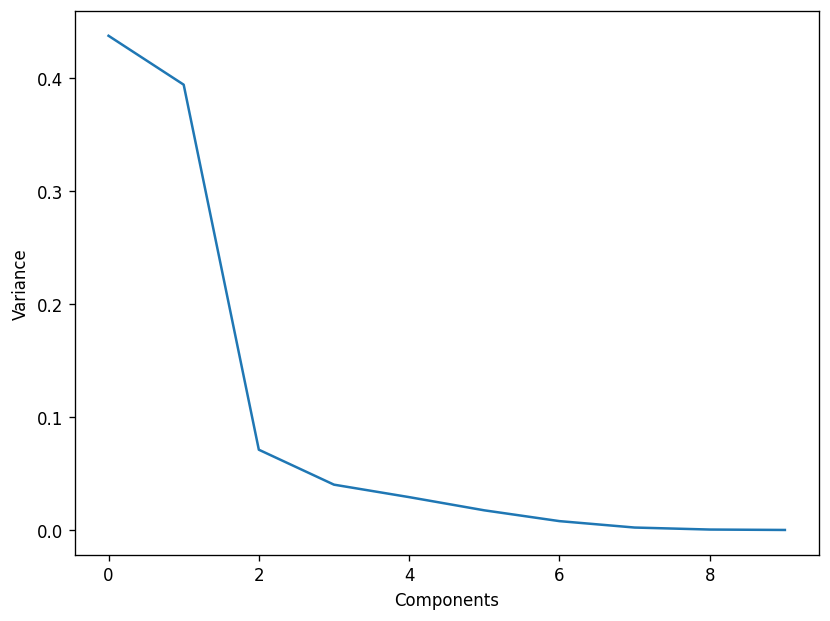

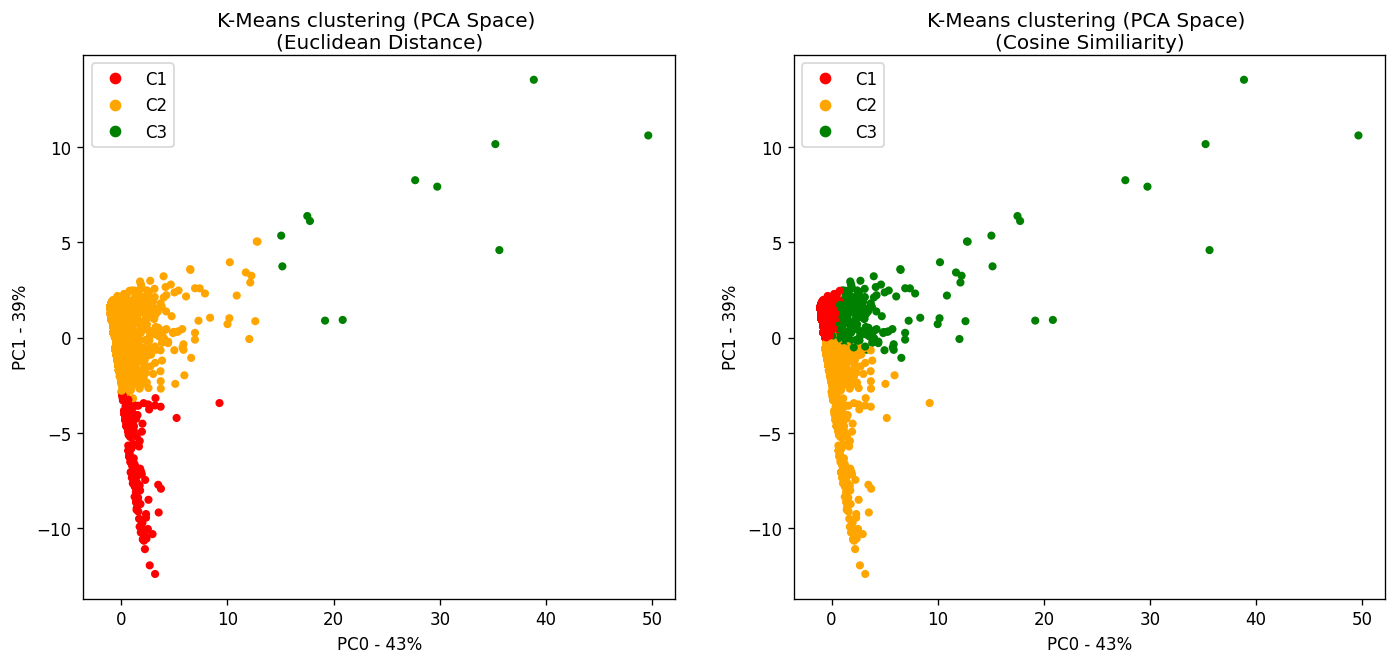

K-means with Euclidean Distance:


,C1,C2,C3
Number of Classes,216,3272,12


K-means with Cosine Similarity:


,C1,C2,C3
Number of Classes,2047,1215,238


Standardized/Normalized books features matrix : 


,Nb rating,Average Rating,Bayes Rating,Median,STD,Depreciation,Neutral,Appreciations,MaxStarVotes,Class
B00CAC06SM,-0.055560,-0.521448,-0.609653,-0.417220,-0.072496,-0.068916,0.158431,-0.081489,-0.357895,0.097063
1440491860,-0.158328,0.423914,0.441100,0.511094,-0.136047,-0.256834,-0.270541,-0.123912,0.372762,0.165747
1591864925,-0.114857,0.312981,0.372213,0.618735,-0.099041,-0.310926,0.065504,-0.113108,0.451270,0.200654
0618788220,-0.271368,0.033747,0.033694,0.663324,-0.240684,-0.152734,-0.210673,-0.279501,0.483790,0.215114
1402791046,-0.134903,0.681421,0.533064,0.310883,-0.093710,-0.156225,-0.164562,-0.121725,0.226740,0.100819
...,...,...,...,...,...,...,...,...,...,...
0806129085,-0.161203,-0.495096,-0.442191,-0.584775,-0.191661,-0.096592,-0.044411,-0.176762,0.305959,0.136043
0310325501,0.453030,0.100201,0.160602,0.210867,0.511192,0.353325,0.290212,0.464497,0.153794,0.068384
067978117X,-0.073710,-0.306548,-0.237367,-0.236787,-0.074807,-0.085360,0.017983,-0.081705,-0.530124,-0.698048
0156006022,-0.191716,-0.176824,-0.145473,-0.653252,-0.188936,-0.235492,-0.148836,-0.183487,-0.560365,0.151973


PC axis composition : 


,PC0,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9
Nb rating,0.039588,0.071221,0.475091,-0.035039,-0.074458,-0.040315,-0.120733,-0.168677,-0.365067,-7.635113e-01
Average Rating,-0.499573,0.467890,0.008183,0.110791,0.069594,0.003799,0.478807,-0.523285,0.105941,1.665335e-16
Bayes Rating,-0.499697,0.473377,0.041186,0.035739,0.012063,-0.042744,-0.232001,0.668851,-0.141719,1.179612e-16
Median,-0.571406,-0.500588,0.054193,-0.632670,-0.104571,0.085088,0.023859,-0.028869,-0.010994,5.551115e-17
STD,-0.004606,0.114587,0.454188,-0.078461,-0.064465,-0.132272,-0.344871,-0.067143,0.793290,-6.106227e-16
Depreciation,0.121270,-0.123271,0.364409,-0.080239,0.175656,-0.578672,0.594440,0.326968,0.005821,6.963207e-02
Neutral,0.111360,-0.002677,0.418383,0.059719,-0.105876,0.770167,0.362403,0.246883,0.065658,8.953735e-02
Appreciations,0.018578,0.099412,0.471726,-0.041702,-0.093748,-0.093503,-0.261141,-0.273154,-0.448312,6.357553e-01
MaxStarVotes,-0.371751,-0.503625,0.174387,0.699998,0.271987,-0.001745,-0.116246,-0.012617,0.010186,3.469447e-17
Class,-0.083579,-0.097361,-0.050269,0.277582,-0.921708,-0.187172,0.128199,0.048853,0.023571,3.469447e-17


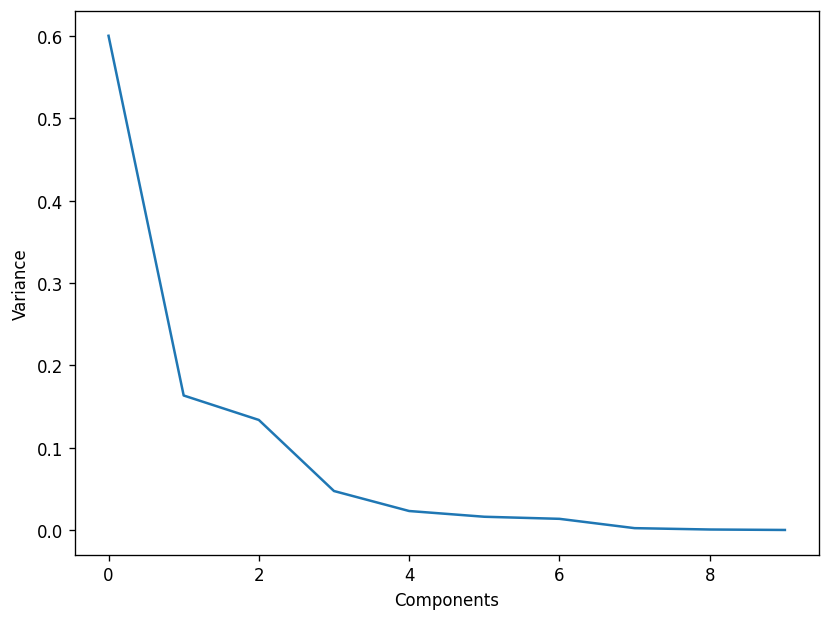

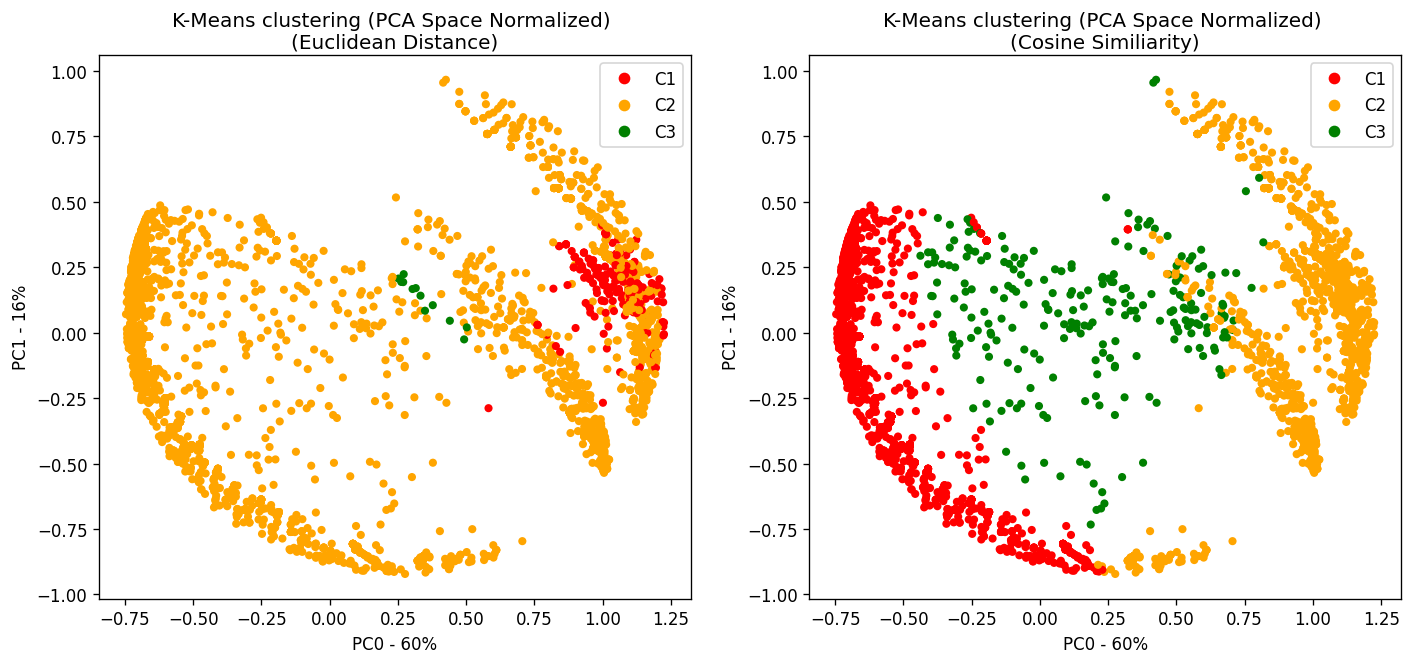

In [10]:
def scatterPlotHelper(plotData):
    fig, ax = plt.subplots(1, len(plotData), figsize=(14,6), dpi=120)
    for i in range(len(plotData)):
        if (plotData[i].axisLabels != []): ax[i].set(xlabel=plotData[i].axisLabels[0], ylabel=plotData[i].axisLabels[1])
        scatter = ax[i].scatter(x=plotData[i].dataXY[0], y=plotData[i].dataXY[1], c=plotData[i].dataLabels, cmap=colors, s=15)
        ax[i].legend(handles=scatter.legend_elements(num=3)[0], labels=CLASSES)
        ax[i].set_title(plotData[i].title, loc='center', wrap=True)
    plt.show()


def calculatePCA(booksData, normalize=False):
    # Data Standardization
    pdBooksFeaturesStandardized = (booksData - booksData.mean()) / booksData.std()
    if (normalize):
        pdBooksFeaturesNormalized = pd.DataFrame(
            data=preprocessing.normalize(pdBooksFeaturesStandardized), 
            columns=booksData.columns, 
            index=booksData.index
        )
    else:
        pdBooksFeaturesNormalized = pdBooksFeaturesStandardized
    # PCA Calculations
    pca = PCA(n_components=booksData.shape[1])
    pca.fit(pdBooksFeaturesNormalized)
    # PCA Results
    booksFeaturesPCA = pd.DataFrame(
        data=pca.components_.T,
        columns=[f"PC{i}" for i in range(len(booksData.columns))],
        index=booksData.columns
    )
    return pdBooksFeaturesNormalized, booksFeaturesPCA, pca

def displayPCAResults(pdBooksFeaturesStandNorm, booksFeaturesPCA, pca):
    # Display standardized data 
    print("Standardized/Normalized books features matrix : ")
    display(pdBooksFeaturesStandNorm)
    # Plot all PCA axis and their contributions
    print("PC axis composition : ")
    display(booksFeaturesPCA)
    # Plot PCA (2 major axis)
    plt.figure(figsize=(8, 6), dpi=120)
    plt.plot(pca.explained_variance_ratio_)
    plt.ylabel("Variance")
    plt.xlabel("Components")
    plt.show()

def displayKmeansClustering(booksData, normalizePca=False, displayPcaResults=False):
    kmeansEucliCoords, kmeansEucliLabels = kmeansClustering(booksData, "euclidean")
    kmeansCosCoords, kmeansCosLabels = kmeansClustering(booksData, "cosine")
    pdBooksFeaturesStandNorm, booksFeaturesPCA, pca = calculatePCA(booksData, normalizePca)
    if (displayPcaResults): displayPCAResults(pdBooksFeaturesStandNorm, booksFeaturesPCA, pca)
    pcaSpace = pca.transform(pdBooksFeaturesStandNorm)
    pcaSpaceXY = (pcaSpace[:,0], pcaSpace[:,1])
    pcaAxisLabels = [f"PC0 - {math.floor(pca.explained_variance_ratio_[0]*100)}%", f"PC1 - {math.floor(pca.explained_variance_ratio_[1]*100)}%"]
    kmeansEucli = PlotData(
        inputData=kmeansEucliCoords,
        dataXY=pcaSpaceXY,
        dataLabels=kmeansEucliLabels, 
        title=f"K-Means clustering (PCA Space{' Normalized' if normalizePca else ''}) \n(Euclidean Distance)",
        axisLabels=pcaAxisLabels
    )
    kmeansCos = PlotData(
        inputData=kmeansCosCoords,
        dataXY=pcaSpaceXY,
        dataLabels=kmeansCosLabels, 
        title=f"K-Means clustering (PCA Space{' Normalized' if normalizePca else ''}) \n(Cosine Similiarity)",
        axisLabels=pcaAxisLabels
    )
    scatterPlotHelper([kmeansEucli, kmeansCos])
    return kmeansEucli, kmeansCos

kmeansEucli, kmeansCos = displayKmeansClustering(pdBooksFeatures, normalizePca=False, displayPcaResults=True)
kmeansEucliNorm, kmeansCosNorm = displayKmeansClustering(pdBooksFeatures, normalizePca=True, displayPcaResults=True)

**Q3 : Interprétation des résultats visuelles**
TODO

Spectral clustering with Euclidean Distance : 


,C1,C2,C3
Number of Classes,180,3312,8


Spectral clustering with Cosine Similarity : 


,C1,C2,C3
Number of Classes,594,1270,1636


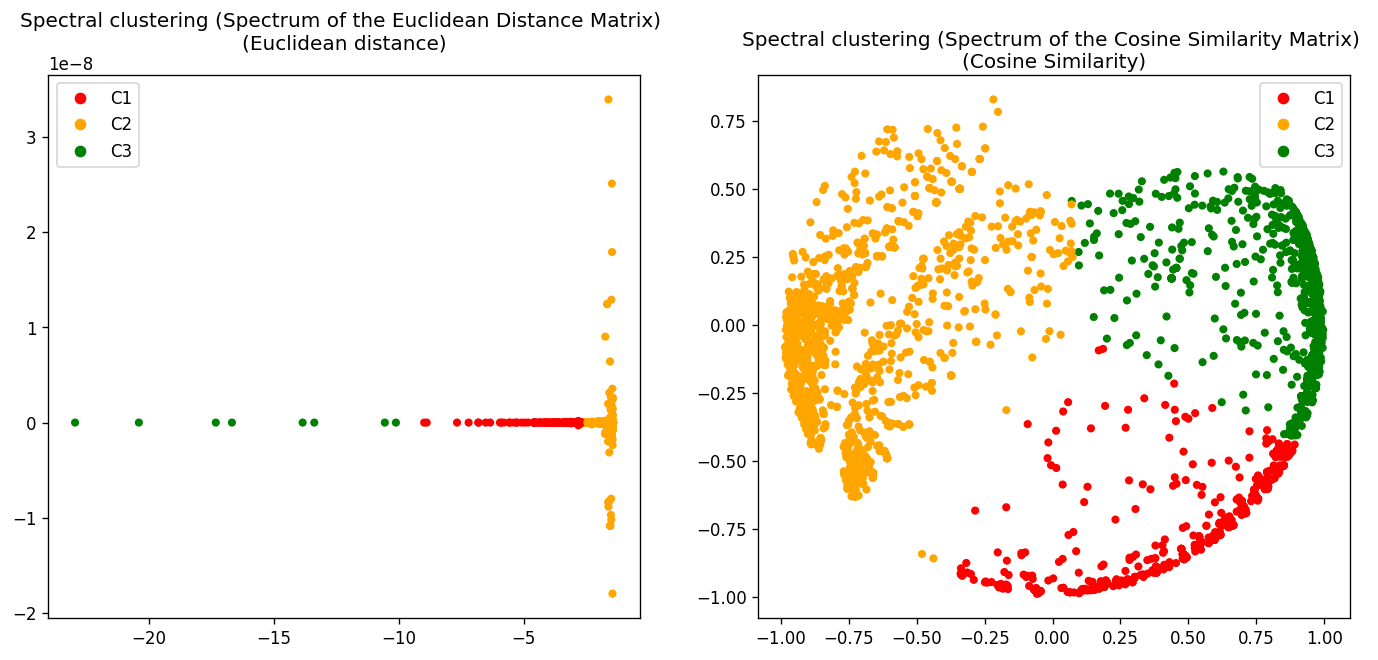

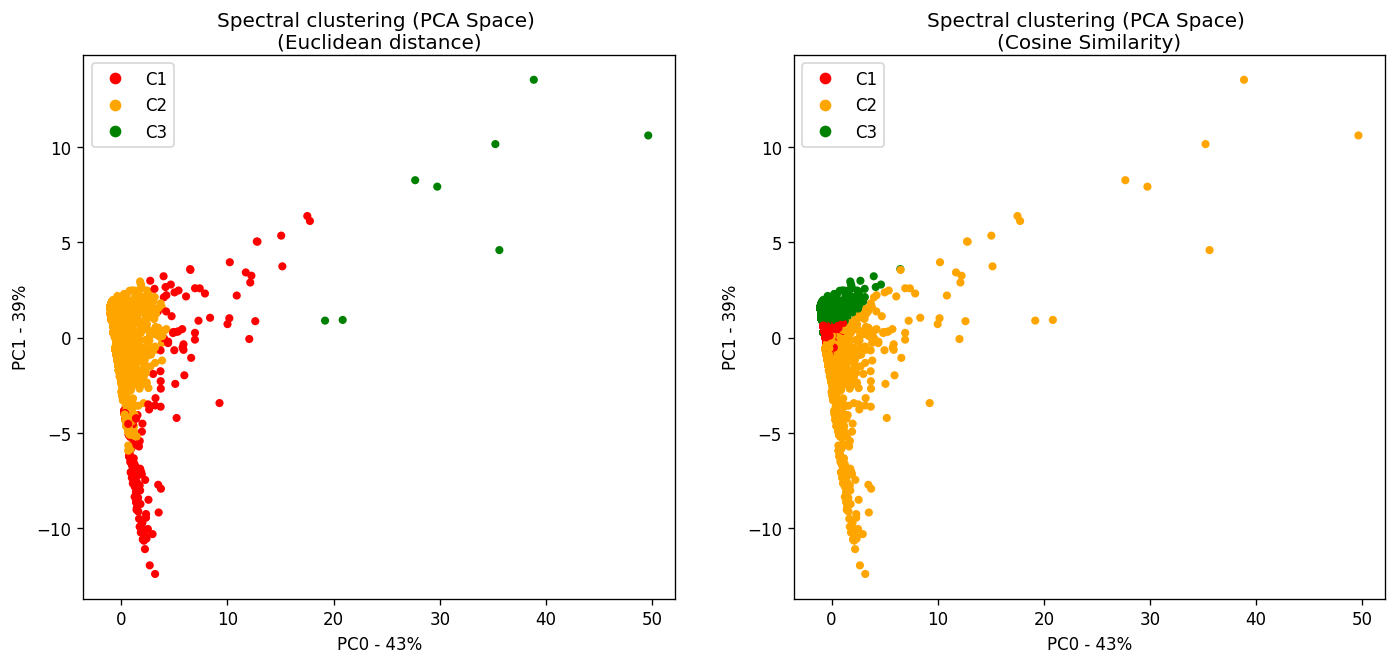

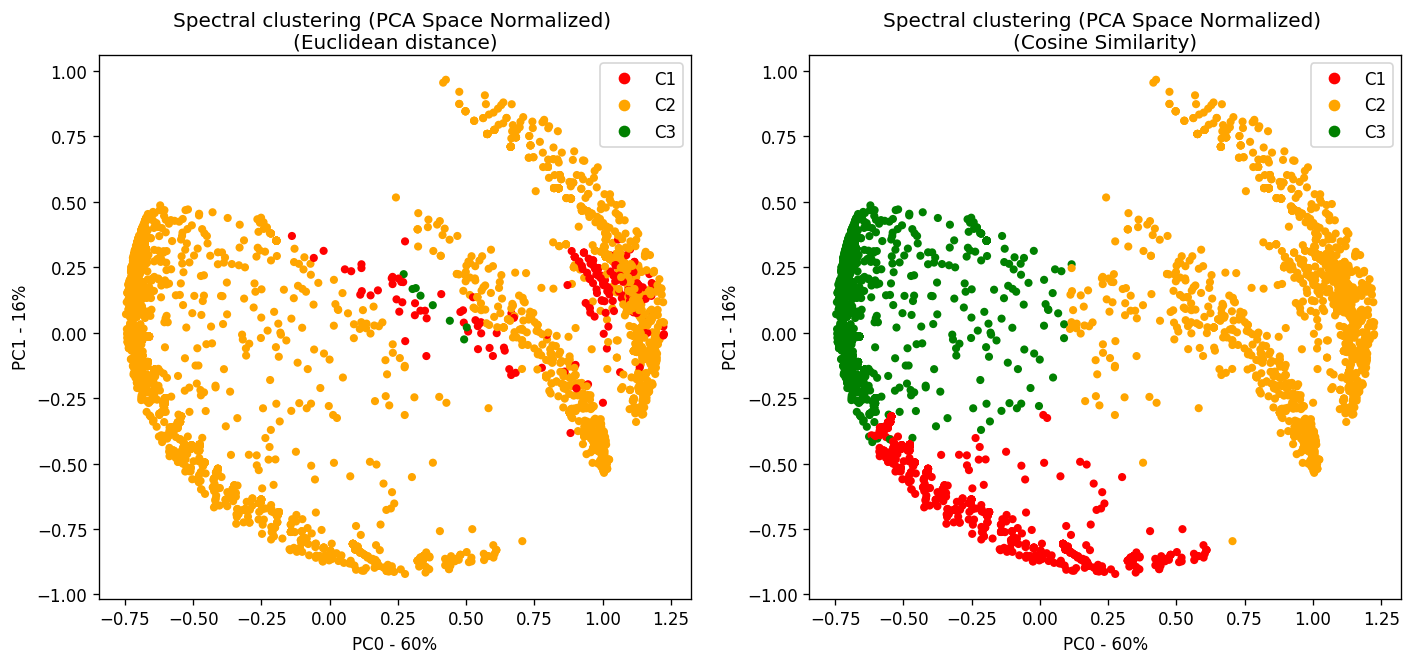

In [11]:
# Q4
def spectralClustering(booksData, distFunc):
    # Standardize data before doing kmeans :
    data = (booksData - booksData.mean()) / booksData.std()
    # https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.distance.pdist.html
    M = sp.spatial.distance.squareform(sp.spatial.distance.pdist(np.asarray(data), distFunc))
    if (distFunc == "cosine"): M = 1 - M # SciPy uses distance cos which is equal to 1 - sim cos
    eigenValues, eigenVectors = np.linalg.eig(M)
    idx =  eigenValues.argsort()[::-1]
    eigenValues = eigenValues[idx].real
    eigenVectors = eigenVectors[:,idx].real
    positiveCount = eigenValues[eigenValues > 0].size
    P = np.stack(eigenVectors[:,0:positiveCount])
    D = np.diag(eigenValues[0:positiveCount])
    spectralDataMat = P @ np.sqrt(D)
    kmeans = KMeans(n_clusters=NB_CLUSTERS, random_state=0, max_iter=1000).fit(spectralDataMat[:,0:2])
    return spectralDataMat[:,0:2], kmeans.labels_

def displaySpectralClustering(booksData, kmeansEucli, kmeansCos, kmeansEucliNorm, kmeansCosNorm):
    eucliCoords, spectralEucliLabels = spectralClustering(booksData, "euclidean")
    cosCoords, spectralCosLabels =  spectralClustering(booksData, "cosine")
    print("Spectral clustering with Euclidean Distance : ")
    display(pd.DataFrame(
        data=np.array([[np.count_nonzero(spectralEucliLabels == i) for i in range(0, NB_CLUSTERS)]]),
        index=["Number of Classes"],
        columns=CLASSES
    ))
    print("Spectral clustering with Cosine Similarity : ")
    display(pd.DataFrame(
        data=np.array([[np.count_nonzero(spectralCosLabels == i) for i in range(0, NB_CLUSTERS)]]),
        index=["Number of Classes"],
        columns=CLASSES
    ))
    spectralEucli = PlotData(
        inputData=eucliCoords,
        dataXY=(eucliCoords[:,0],eucliCoords[:,1]), 
        dataLabels=spectralEucliLabels, 
        title="Spectral clustering (Spectrum of the Euclidean Distance Matrix) \n(Euclidean distance)"
    )
    spectralCos = PlotData(
        inputData=cosCoords,
        dataXY=(cosCoords[:,0],cosCoords[:,1]), 
        dataLabels=spectralCosLabels, 
        title="Spectral clustering (Spectrum of the Cosine Similarity Matrix) \n(Cosine Similarity)"
    )
    scatterPlotHelper([spectralEucli, spectralCos])
    spectralEucliPCASpace = PlotData(
        inputData=eucliCoords,
        dataXY=kmeansEucli.dataXY, 
        dataLabels=spectralEucliLabels, 
        title="Spectral clustering (PCA Space) \n(Euclidean distance)",
        axisLabels=kmeansEucli.axisLabels
    )
    spectralCosPCASpace = PlotData(
        inputData=cosCoords,
        dataXY=kmeansCos.dataXY, 
        dataLabels=spectralCosLabels, 
        title="Spectral clustering (PCA Space) \n(Cosine Similarity)",
        axisLabels=kmeansCos.axisLabels
    )
    scatterPlotHelper([spectralEucliPCASpace, spectralCosPCASpace])
    spectralEucliPCASpaceNorm = PlotData(
        inputData=eucliCoords,
        dataXY=kmeansEucliNorm.dataXY, 
        dataLabels=spectralEucliLabels, 
        title="Spectral clustering (PCA Space Normalized) \n(Euclidean distance)",
        axisLabels=kmeansEucliNorm.axisLabels
    )
    spectralCosPCASpaceNorm = PlotData(
        inputData=cosCoords,
        dataXY=kmeansCosNorm.dataXY, 
        dataLabels=spectralCosLabels, 
        title="Spectral clustering (PCA Space Normalized) \n(Cosine Similarity)",
        axisLabels=kmeansCosNorm.axisLabels
    )
    scatterPlotHelper([spectralEucliPCASpaceNorm, spectralCosPCASpaceNorm])
    return spectralEucli, spectralCos, spectralEucliPCASpace, spectralCosPCASpace, spectralEucliPCASpaceNorm, spectralCosPCASpaceNorm

spectralEucli, spectralCos, spectralEucliPCASpace, spectralCosPCASpace, spectralEucliPCASpaceNorm, spectralCosPCASpaceNorm = displaySpectralClustering(
    pdBooksFeatures[CRITERIAS], 
    kmeansEucli,
    kmeansCos,
    kmeansEucliNorm,
    kmeansCosNorm
)

In [12]:
# Q5
def getAccuracyMatrix(pdBooksFeatures, kmeansEucli, kmeansCos, spectralEucli, spectralCos):
    bookClasses = pdBooksFeatures[["Class"]].to_numpy(dtype=int).T[0]
    perfMetric = np.array([
        [
            sk.metrics.silhouette_score(kmeansEucli.inputData, kmeansEucli.dataLabels, metric='euclidean'), 
            sk.metrics.adjusted_mutual_info_score(kmeansEucli.dataLabels, bookClasses), 
            sk.metrics.silhouette_score(kmeansCos.inputData, kmeansCos.dataLabels, metric="cosine"), 
            sk.metrics.adjusted_mutual_info_score(kmeansCos.dataLabels, bookClasses), 
        ],
        [
            sk.metrics.silhouette_score(spectralEucli.inputData, spectralEucli.dataLabels, metric='euclidean'), 
            sk.metrics.adjusted_mutual_info_score(spectralEucli.dataLabels, bookClasses), 
            sk.metrics.silhouette_score(spectralCos.inputData, spectralCos.dataLabels, metric="cosine"), 
            sk.metrics.adjusted_mutual_info_score(spectralCos.dataLabels, bookClasses), 
        ],
    ])
    return perfMetric

def displayAccuracyMatrix(pdBooksFeatures, kmeansClustering, spectraClustering):
    accMat = getAccuracyMatrix(
        pdBooksFeatures, 
        kmeansClustering[0], 
        kmeansClustering[1], 
        spectraClustering[0], 
        spectraClustering[1]
    )
    display(pd.DataFrame(
        data=accMat, 
        columns=["Silhouet (Euclidean)", "Mut. Info. (Euclidean)", "Silhouet (Cosine)", "Mut. Info. (Cosine)",],
        index=["K-means", "Spectral"]
    ))
    return accMat

_ = displayAccuracyMatrix(
    pdBooksFeatures,
    (kmeansEucli, kmeansCos), 
    (spectralEucli, spectralCos), 
)

,Silhouet (Euclidean),Mut. Info. (Euclidean),Silhouet (Cosine),Mut. Info. (Cosine)
K-means,0.664113,0.623586,0.653330,0.091928
Spectral,0.854935,0.314581,0.804135,0.076547


**b-1) Selon vous quel serait le risque de prendre aléatoirement un sous-ensemble de données pour effectuer les tâches a-1) à a-5) ?**

-> Puisque les 3 catégories ne sont pas distrbué d'une maniere uniforme si on prend aléatoirement un sous ensemble de données, on risque d'avoir des catégories qui seront forcément sous représenter voir même pas présent. Par conséquence, notre clustering sera forcément faux car on risque d'appliquer l'algorithme de clustering sur un ensemble de données qui appartient au même groupe (qui n'as pas de sens).

,1 ⭐,2 ⭐,3 ⭐,4 ⭐,5 ⭐,Depreciation,Neutral,Appreciations,MaxStarVotes,Class
1859843778,5,0,0,1,3,5,0,4,0,0
0425182673,5,2,3,2,1,7,3,3,0,0
0380781824,0,5,2,1,2,5,2,3,1,0
0399153152,7,7,6,4,5,14,6,9,0,0
B006B1X5KY,2,2,1,1,1,4,1,2,0,0
...,...,...,...,...,...,...,...,...,...,...
141657218X,0,2,2,2,4,2,2,6,4,2
0061043974,0,3,5,12,10,3,5,22,3,2
0345441095,0,0,0,1,4,0,0,5,4,2
B0048ELAY4,4,0,1,2,5,4,1,7,4,2


,Nb rating,Average Rating,Bayes Rating,Median,STD,Depreciation,Neutral,Appreciations,MaxStarVotes,Class
1859843778,9.0,2.666667,2.988498,1.0,1.939072,5.0,0.0,4.0,0.0,0.0
0425182673,13.0,2.384615,2.727762,2.0,1.356466,7.0,3.0,3.0,0.0,0.0
0380781824,10.0,3.000000,3.176717,3.0,1.673320,5.0,2.0,3.0,1.0,0.0
0399153152,29.0,2.758621,2.880785,3.0,1.166190,14.0,6.0,9.0,0.0,0.0
B006B1X5KY,7.0,2.571429,2.986728,2.0,0.489898,4.0,1.0,2.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...
141657218X,10.0,3.800000,3.676717,4.0,1.264911,2.0,2.0,6.0,4.0,2.0
0061043974,30.0,3.966667,3.884096,4.0,4.427189,3.0,5.0,22.0,3.0,2.0
0345441095,5.0,4.800000,4.075225,5.0,1.549193,0.0,0.0,5.0,4.0,2.0
B0048ELAY4,12.0,3.333333,3.379304,4.0,1.854724,4.0,1.0,7.0,4.0,2.0


Different classes count : 


,Count,%
⭐,3500,33
⭐⭐,3500,33
⭐⭐⭐,3500,33


K-means with Euclidean Distance:


,C1,C2,C3
Number of Classes,7001,3431,68


K-means with Cosine Similarity:


,C1,C2,C3
Number of Classes,6171,508,3821


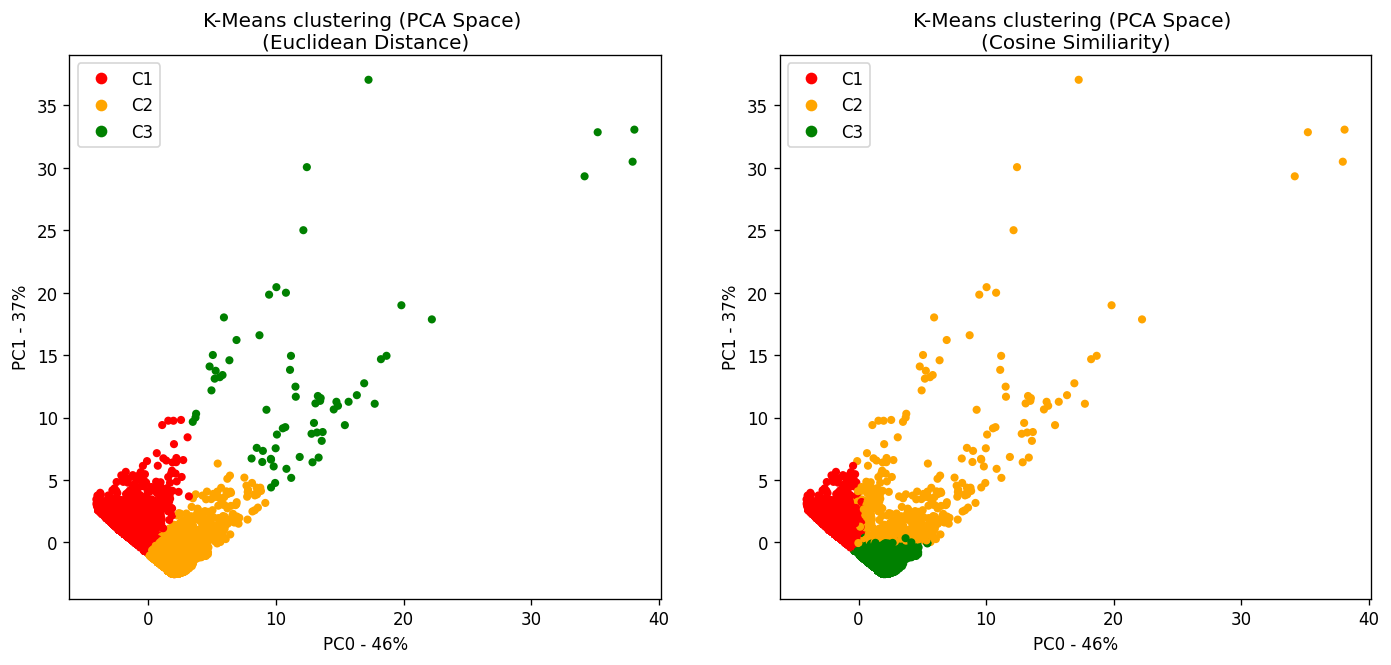

K-means with Euclidean Distance:


,C1,C2,C3
Number of Classes,7001,3431,68


K-means with Cosine Similarity:


,C1,C2,C3
Number of Classes,6171,508,3821


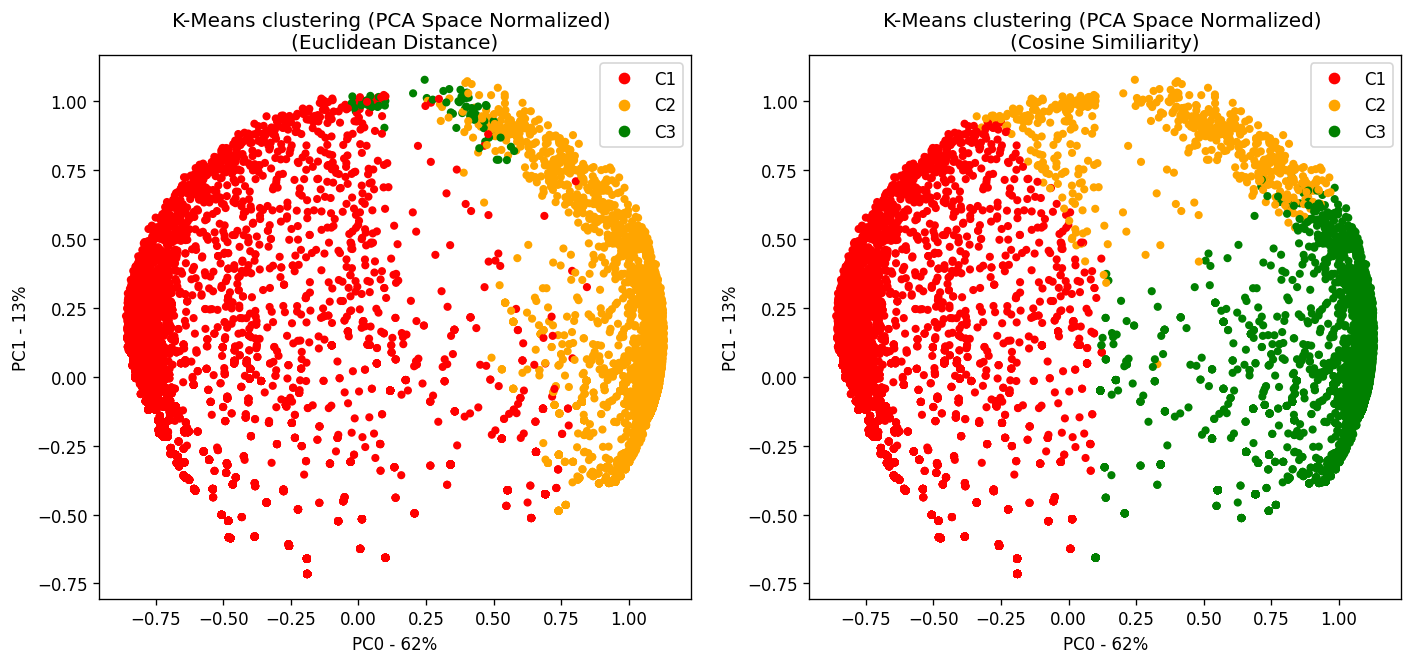

Spectral clustering with Euclidean Distance : 


,C1,C2,C3
Number of Classes,10412,81,7


Spectral clustering with Cosine Similarity : 


,C1,C2,C3
Number of Classes,2286,4321,3893


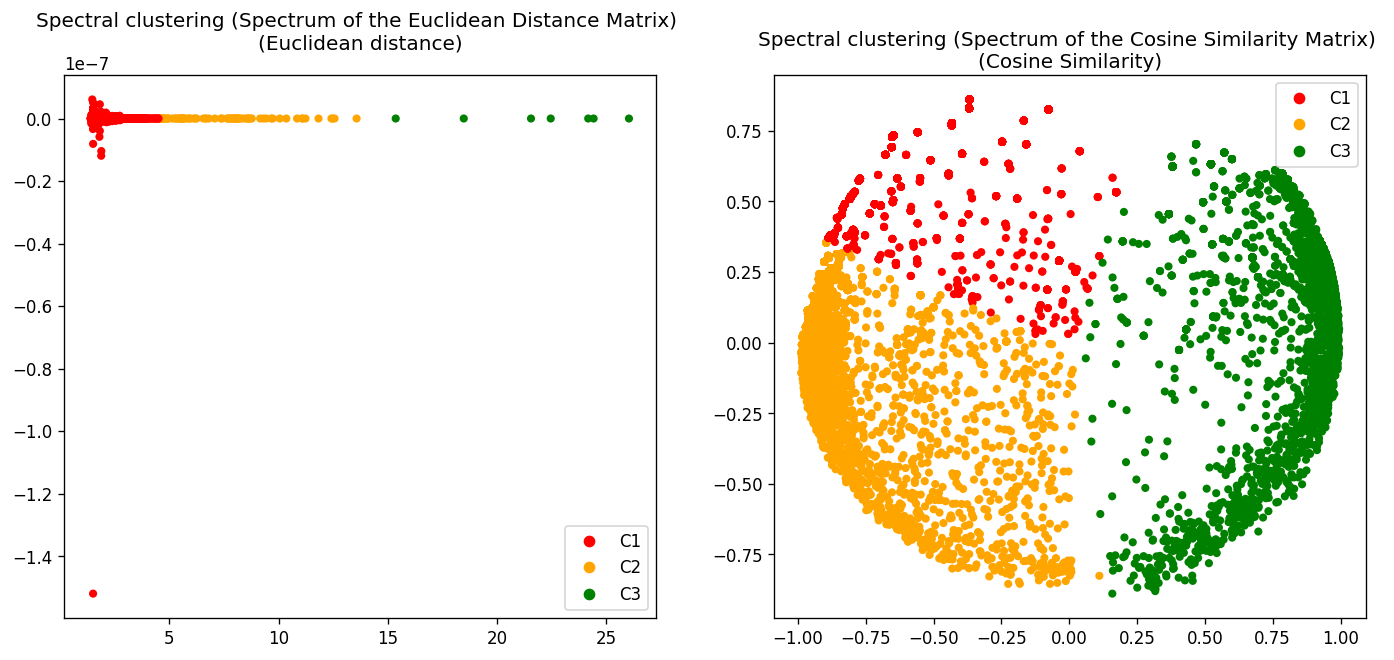

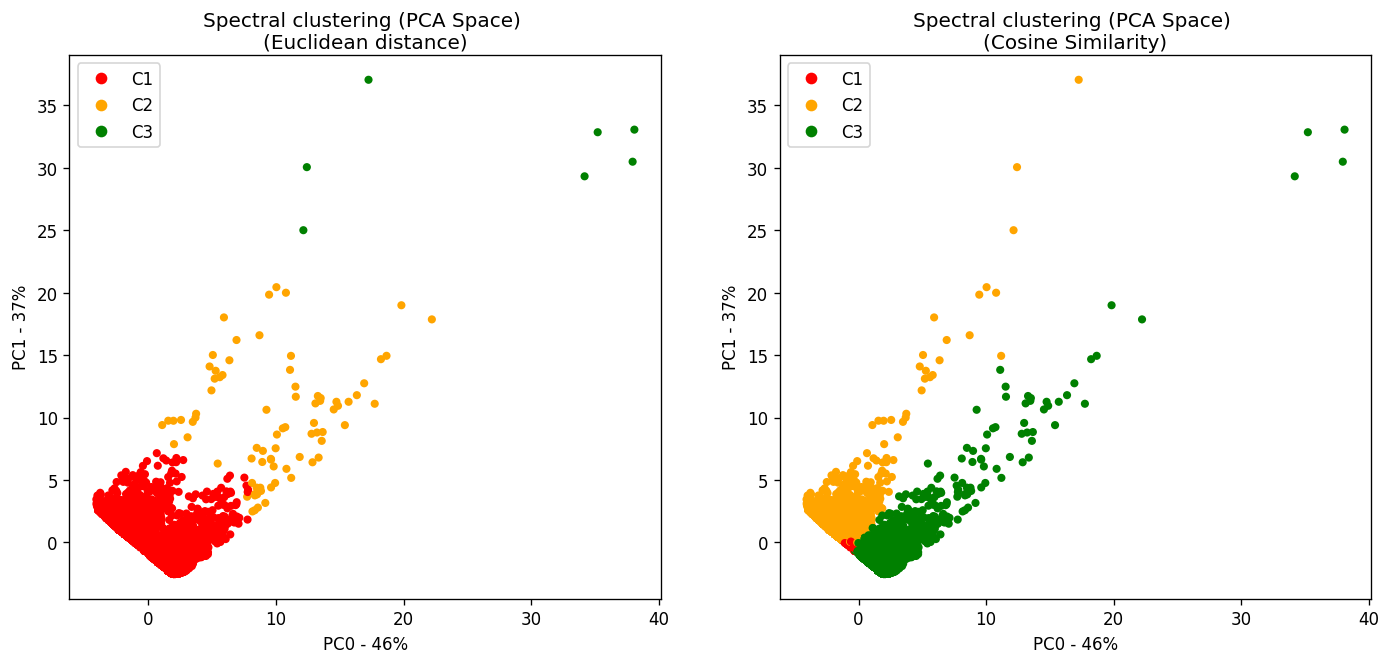

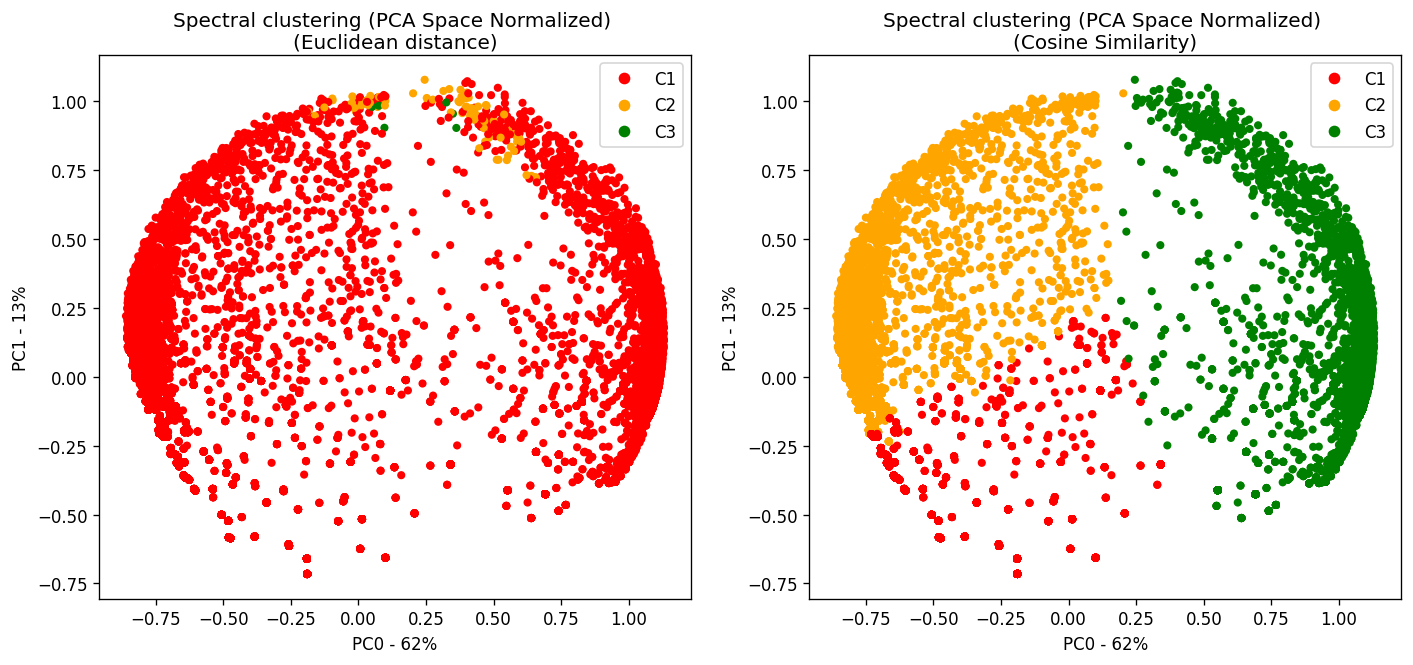

,Silhouet (Euclidean),Mut. Info. (Euclidean),Silhouet (Cosine),Mut. Info. (Cosine)
K-means,0.497958,0.564137,0.638156,0.432017
Spectral,0.932466,0.006910,0.748770,0.531336


In [13]:
# Q B-3
def fullAnalysis(pdBooksFeatures):
    kmeansEucli, kmeansCos = displayKmeansClustering(pdBooksFeatures[CRITERIAS])
    kmeansEucliNorm, kmeansCosNorm = displayKmeansClustering(pdBooksFeatures[CRITERIAS], normalizePca=True)
    spectralEucli, spectralCos, _, _, _, _ = displaySpectralClustering(
        pdBooksFeatures[CRITERIAS], 
        kmeansEucli,
        kmeansCos,
        kmeansEucliNorm,
        kmeansCosNorm
    )
    displayAccuracyMatrix(
        pdBooksFeatures, 
        (kmeansEucli, kmeansCos), 
        (spectralEucli, spectralCos)
    )

#classesCount = [ (pdBooks.Class.values == i).sum() for i in range(0, 3) ]
# nbSamples = np.min(classesCount)
nbSamples = BOOKS_SAMPLING_NB
pdBooksSampled = pdBooks.groupby('Class', group_keys=False).apply(lambda x: x.sample(nbSamples))
display(pdBooksSampled)

pdSampledBooksFeatures = getBookStats(pdBooksSampled)
display(pdSampledBooksFeatures)
displayDifferentClassesCount(pdSampledBooksFeatures)

fullAnalysis(pdSampledBooksFeatures)